# Case Study: Predicting Booking Cancellations for INN Hotels Group
**Objective**

To develop a predictive model that forecasts the likelihood of booking cancellations, allowing INN Hotels Group to take proactive measures to reduce revenue loss due to inventory vacancies.

## Step-by-Step Implementation

In [6]:
# Step 1: Data Understanding and Preprocessing
# Load the Data

import pandas as pd
df = pd.read_csv('/content/INNHotelsGroup.csv')


In [ ]:
df.columns

Index(['lead_time', 'market_segment_type', 'no_of_special_requests',
       'avg_price_per_room', 'no_of_adults', 'no_of_weekend_nights',
       'arrival_date', 'required_car_parking_space', 'no_of_week_nights',
       'booking_status'],
      dtype='object')

In [ ]:
# Inspect data
print(df.head())
print(df.info())
print(df.describe())


   lead_time market_segment_type  no_of_special_requests  avg_price_per_room  \
0        224             Offline                       0               65.00   
1          5              Online                       1              106.68   
2          1              Online                       0               60.00   
3        211              Online                       0              100.00   
4         48              Online                       0               94.50   

   no_of_adults  no_of_weekend_nights arrival_date  \
0             2                     1   2017-10-02   
1             2                     2   2018-11-06   
2             1                     2   2018-02-28   
3             2                     0   2018-05-20   
4             2                     1   2018-04-11   

   required_car_parking_space  no_of_week_nights booking_status  
0                           0                  2   Not_Canceled  
1                           0                  3   Not_Cancele

In [ ]:
# Handle Missing Values
df.isnull().sum()


lead_time                     0
market_segment_type           0
no_of_special_requests        0
avg_price_per_room            0
no_of_adults                  0
no_of_weekend_nights          0
arrival_date                  0
required_car_parking_space    0
no_of_week_nights             0
booking_status                0
dtype: int64

In [ ]:
# Data transformation
df['arrival_date'] = pd.to_datetime(df['arrival_date'])

# Encode Categorical Variables
# Encode categorical variables like market_segment_type to numeric using one-hot encoding for model compatibility
df = pd.get_dummies(df, columns=['market_segment_type'], drop_first=True)

# Convert 'booking_status' column to numeric
df['booking_status'] = df['booking_status'].map({'Not_Canceled': 0, 'Canceled': 1})


In [ ]:
# Feature Engineering
# Create new features such as total_nights to potentially enhance model performance
df['total_nights'] = df['no_of_weekend_nights'] + df['no_of_week_nights']
df['booking_year'] = df['arrival_date'].dt.year
df['booking_month'] = df['arrival_date'].dt.month

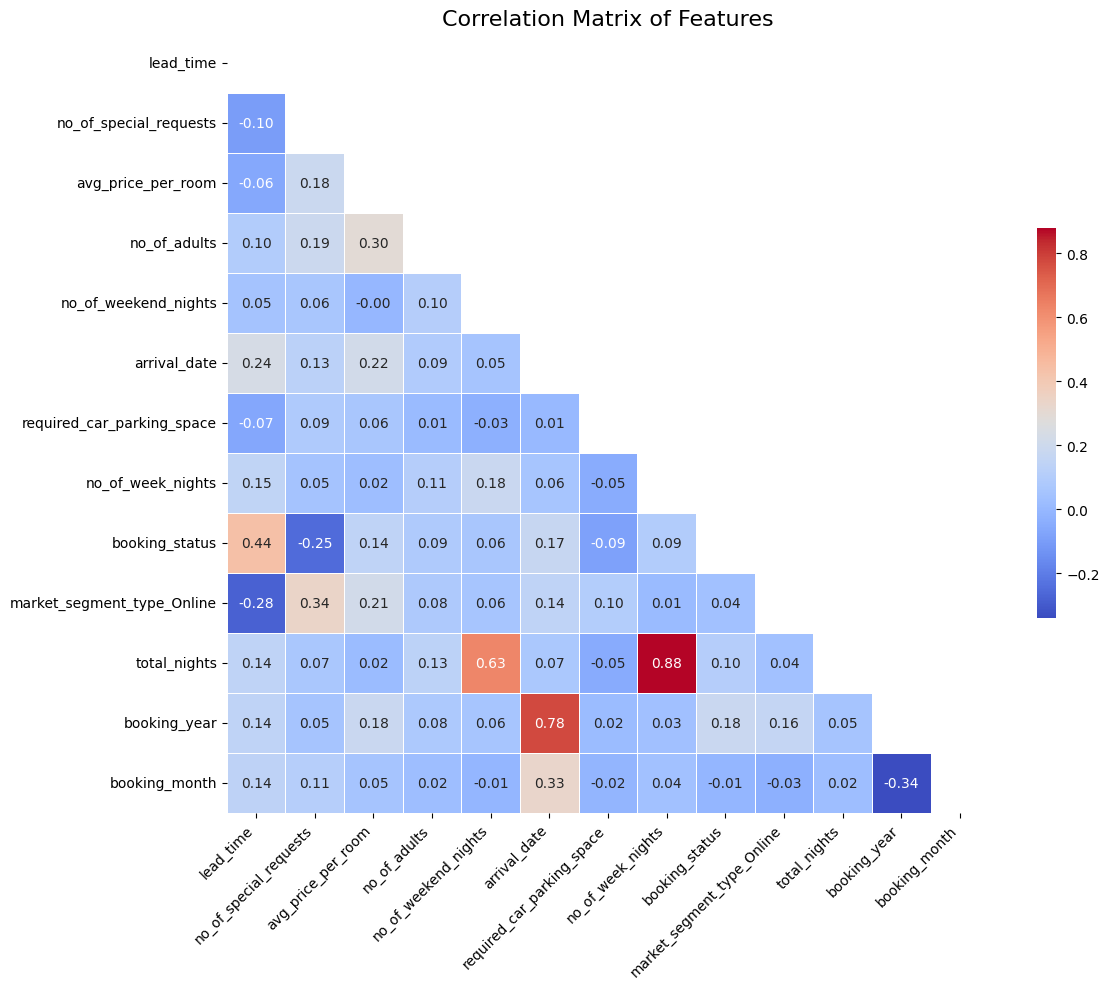

In [ ]:
# Step 2: Exploratory Data Analysis (EDA)
# Visualize correlations between features and identify potential predictors of booking cancellations
# Correlation Analysis
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the correlation matrix
correlation_matrix = df.corr()

# Create a mask to hide the upper triangle of the matrix
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5, cbar_kws={"shrink": .5})

# Set the title for better readability
plt.title('Correlation Matrix of Features', size=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()





**Key observations from the matrix**
- There is a strong positive correlation (0.78) between booking year and booking month, suggesting that as the year progresses, there might be a trend or shift in the months through bookings made.
- Total nights have a moderate positive correlation (0.63) with booking month, indicating that stays may be more common in certain months.
- There is a notable negative correlation (-0.44) between booking status and lead time, which could imply that longer lead times might decrease the likelihood of a booking being confirmed or successful.
- Market Segment Type Online and No of Special Requests show a moderate positive correlation (0.34), suggesting that online bookings tend to have more requests.

**Suggestions for Model Building**
1. **Feature Selection**. Based on the correlation matrix, we shall consider including features with significant correlations as predictors or for creating interaction terms. For example, booking year and month might improve a model predicting booking trends or customer behaviour.
   
2. **Multicollinearity Check**. Before finalising the model, we shall check for multicollinearity and highly correlated features, especially between booking year and month. That can impact the performance and interpretability of the model.

3. **Temporal Analysis**. Given the strong correlations involving booking month and booking year, incorporating time series analysis or adding temporal features might yield better predictive performance.

4. **Customer Segmentation**. The correlations involving market segment type and special requests suggest different customer behaviours based on the booking channel. Segmenting customers based on these features might help tailor marketing strategies or personalised offers.

5. **Predictive Modeling**. Forecasting booking status, we shall consider logistic regression or decision tree models that can handle binary outcomes and provide insights into the feature's importance.



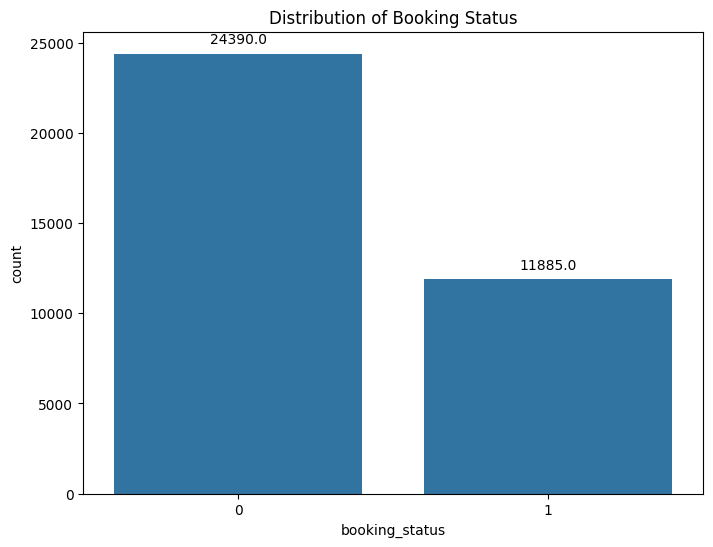

In [ ]:
# Distribution of Booking Status
# Examine the distribution of booking_status to understand the imbalance in the target variable
import matplotlib.pyplot as plt
import seaborn as sns

# Set figure size
plt.figure(figsize=(8, 6))

# Create the count plot
ax = sns.countplot(x='booking_status', data=df)

# Annotate bars with data levels
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Add title
plt.title('Distribution of Booking Status')

# Show the plot
plt.show()


In [ ]:
# # Distribution of Booking Status
# # Examine the distribution of booking_status to understand the imbalance in the target variable
# sns.countplot(x='booking_status', data=df)
# plt.show()


# Step 3: Model Building

In [7]:
# Step 3.1: Feature Selection and Preparation
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix

# Check available columns
print("Columns in the dataset:", df.columns)

# Feature Selection: Define features and target
features = ['lead_time', 'market_segment_type', 'arrival_date']
target = 'booking_status'

Columns in the dataset: Index(['lead_time', 'market_segment_type', 'no_of_special_requests',
       'avg_price_per_room', 'no_of_adults', 'no_of_weekend_nights',
       'arrival_date', 'required_car_parking_space', 'no_of_week_nights',
       'booking_status'],
      dtype='object')


In [8]:
# Remove multicollinearity: Check correlation between 'no_of_week_nights' and 'no_of_weekend_nights'
if 'no_of_week_nights' in df.columns and 'no_of_weekend_nights' in df.columns:
    corr_matrix = df[['no_of_week_nights', 'no_of_weekend_nights']].corr()
    print("Correlation Matrix for 'no_of_week_nights' and 'no_of_weekend_nights':\n", corr_matrix)

    # Drop one of the highly correlated features
    if abs(corr_matrix.loc['no_of_week_nights', 'no_of_weekend_nights']) > 0.7:
        df = df.drop(['no_of_weekend_nights'], axis=1)

# Assess if both 'arrival_date' and 'booking_year' are needed
if 'arrival_date' in df.columns:
    df['arrival_date'] = pd.to_datetime(df['arrival_date'])
    #df['booking_year'] = df['arrival_date'].dt.year

# Prepare data for model
X = df[features]
y = df[target]


Correlation Matrix for 'no_of_week_nights' and 'no_of_weekend_nights':
                       no_of_week_nights  no_of_weekend_nights
no_of_week_nights              1.000000              0.179577
no_of_weekend_nights           0.179577              1.000000


In [9]:
# Step 3.2: Features Engineering
# Create new features such as total_nights to potentially enhance model performance
# 1. Create 'total_nights' feature by combining 'no_of_weekend_nights' and 'no_of_week_nights'
if 'no_of_weekend_nights' in df.columns and 'no_of_week_nights' in df.columns:
    df['total_nights'] = df['no_of_weekend_nights'] + df['no_of_week_nights']

# 2. Create interaction terms
# Convert 'market_segment_type' to binary feature if it's categorical
if 'market_segment_type' in df.columns:
    df['market_segment_type_Online'] = df['market_segment_type'].apply(lambda x: 1 if x == 'Online' else 0)

# Create interaction term: 'lead_time' * 'market_segment_type_Online'
if 'lead_time' in df.columns and 'market_segment_type_Online' in df.columns:
    df['lead_time_x_market_segment_Online'] = df['lead_time'] * df['market_segment_type_Online']

# Display the updated DataFrame with new features
print("\nUpdated DataFrame with new features:\n", df.head())

# Optionally, save the updated DataFrame
df.to_csv('Updated_INNHotelsGroup.csv', index=False)



Updated DataFrame with new features:
    lead_time market_segment_type  no_of_special_requests  avg_price_per_room  \
0        224             Offline                       0               65.00   
1          5              Online                       1              106.68   
2          1              Online                       0               60.00   
3        211              Online                       0              100.00   
4         48              Online                       0               94.50   

   no_of_adults  no_of_weekend_nights arrival_date  \
0             2                     1   2017-10-02   
1             2                     2   2018-11-06   
2             1                     2   2018-02-28   
3             2                     0   2018-05-20   
4             2                     1   2018-04-11   

   required_car_parking_space  no_of_week_nights booking_status  total_nights  \
0                           0                  2   Not_Canceled           

In [10]:
# Step 3.3: Model Implementation
# Logistic Regression: A simple model for binary classification
# Complex models
# Random Forest: Captures non-linear relationships and interactions
# Gradient Boosting Machine (GBM): Another powerful model for capturing complex patterns

import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler

# Load the preprocessed dataset
df = pd.read_csv('/content/Updated_INNHotelsGroup.csv')

# Define features and target
features = ['lead_time', 'market_segment_type_Online', 'arrival_date', 'total_nights', 'lead_time_x_market_segment_Online']
target = 'booking_status'

# Convert 'arrival_date' to numerical format
df['arrival_date'] = pd.to_datetime(df['arrival_date']).map(pd.Timestamp.toordinal)

# Prepare data
X = df[features]
y = df[target]

In [11]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)


In [12]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()
}

# Evaluate models using cross-validation
for model_name, model in models.items():
    print(f"Evaluating {model_name}.")

    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"Cross-validation scores: {cv_scores}")
    print(f"Mean CV accuracy: {cv_scores.mean():.4f}")

    # Fit and evaluate the model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Test Accuracy for {model_name}: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred))
    print("-" * 50)



Evaluating Logistic Regression.
Cross-validation scores: [0.74286277 0.74345344 0.74990154 0.75344624 0.75403702]
Mean CV accuracy: 0.7487
Test Accuracy for Logistic Regression: 0.7559
              precision    recall  f1-score   support

    Canceled       0.72      0.44      0.54      3607
Not_Canceled       0.77      0.91      0.83      7276

    accuracy                           0.76     10883
   macro avg       0.74      0.68      0.69     10883
weighted avg       0.75      0.76      0.74     10883

--------------------------------------------------
Evaluating Random Forest.
Cross-validation scores: [0.80626108 0.79877929 0.81410004 0.80838913 0.81252462]
Mean CV accuracy: 0.8080
Test Accuracy for Random Forest: 0.8112
              precision    recall  f1-score   support

    Canceled       0.73      0.68      0.71      3607
Not_Canceled       0.85      0.87      0.86      7276

    accuracy                           0.81     10883
   macro avg       0.79      0.78      0.78   

# Model Interpretation

**Insights**

- **Random Forest** has the highest mean cross-validation accuracy and test accuracy, indicating it generally performs better than the other models. It also provides a good balance between precision and recall for both classes.
- **Logistic Regression** has revealed decent performance but lags behind Random Forest in cross-validation and test accuracy. It shows a significant imbalance in recall, especially for the 'Canceled' class.
- **Gradient Boosting** has shown lower performance than Random Forest and Logistic Regression in their test accuracy. The recall for 'Canceled' is low, indicating that the model might struggle to classify cancellations correctly.

**Recommendations**

Given the results, the **Random Forest model** seems to be the most robust choice due to its high accuracy and balanced performance across precision and recall.



In [34]:
# Model Evaluation based on most robust one
# Implement a predictive model to identify bookings with a high likelihood of cancellation and take proactive steps to reduce cancellations
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize models
rf = RandomForestClassifier(random_state=42)
# Train Random Forest model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled, y_train)

# Predict on test set
y_pred = rf.predict(X_test_scaled)

# Evaluate the model
print("Test Accuracy for Random Forest:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Test Accuracy for Random Forest: 0.8124597996875862
              precision    recall  f1-score   support

    Canceled       0.73      0.68      0.71      3607
Not_Canceled       0.85      0.88      0.86      7276

    accuracy                           0.81     10883
   macro avg       0.79      0.78      0.78     10883
weighted avg       0.81      0.81      0.81     10883



- The model performs better at identifying Not_Canceled instances compared to Canceled instances, as indicated by higher precision, recall, and F1-score for the Not_Canceled class.
- The overall accuracy of the model is 81.25%, which is a good performance metric.

In [35]:
# Prediction and Proactive Measures
# Predict the probability of cancellation
y_prob = rf.predict_proba(X_test_scaled)[:, 1]

# Set a threshold to identify high-risk bookings (e.g., 0.5)
threshold = 0.5
high_risk_indices = np.where(y_prob > threshold)[0]

# High-risk bookings
high_risk_bookings = X_test.iloc[high_risk_indices]

# Proactive measures (printing high-risk bookings)
print("High-risk bookings:")
print(high_risk_bookings)

# Additional steps for proactive measures
# 1. Send reminders to high-risk bookings
# 2. Offer incentives or discounts to encourage retention
# 3. Adjust booking policies for high-risk periods


High-risk bookings:
       lead_time  market_segment_type_Online  arrival_date  total_nights  \
4968           3                           1        736564             1   
34540          9                           0        736737             3   
36108         24                           1        737053             4   
1553          23                           1        736866             3   
24974          9                           1        736945             2   
...          ...                         ...           ...           ...   
29021        132                           0        736894             6   
17795         42                           1        737000             2   
22305        271                           1        737031             3   
29685         42                           0        736804             2   
1106          11                           1        736797             3   

       lead_time_x_market_segment_Online  
4968                    

# Further Models Improvement


In [13]:
# Hyperparameter Tuning to enhance performance
import pandas as pd
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import numpy as np
from scipy.stats import randint, uniform

# Load the dataset and perform feature engineering (as before)
df = pd.read_csv('/content/Updated_INNHotelsGroup.csv')

# Feature Engineering
if 'no_of_weekend_nights' in df.columns and 'no_of_week_nights' in df.columns:
    df['total_nights'] = df['no_of_weekend_nights'] + df['no_of_week_nights']

if 'market_segment_type' in df.columns:
    df['market_segment_type_Online'] = df['market_segment_type'].apply(lambda x: 1 if x == 'Online' else 0)

if 'lead_time' in df.columns and 'market_segment_type_Online' in df.columns:
    df['lead_time_x_market_segment_Online'] = df['lead_time'] * df['market_segment_type_Online']

# Convert 'arrival_date' to numerical format
df['arrival_date'] = pd.to_datetime(df['arrival_date']).map(pd.Timestamp.toordinal)



In [14]:
# Initialize models
import warnings
warnings.filterwarnings("ignore")
rf = RandomForestClassifier(random_state=42)
gbm = GradientBoostingClassifier(random_state=42)

# Define parameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [50, 100],       # Reduced range
    'max_depth': [10, 20],           # Reduced range
    'min_samples_split': [2, 5]
}

# Option 1: Use Randomized Search to speed up the process
rf_random_search = RandomizedSearchCV(estimator=rf, param_distributions=rf_param_grid, n_iter=10, cv=5, n_jobs=-1, scoring='accuracy', random_state=42)
rf_random_search.fit(X_train, y_train)
print("Best parameters for Random Forest (Randomized Search):", rf_random_search.best_params_)


Best parameters for Random Forest (Randomized Search): {'n_estimators': 100, 'min_samples_split': 5, 'max_depth': 20}


In [15]:
# Option 2: Use Grid Search with reduced folds and sample data
# Sample a subset of the data
X_train_sample, _, y_train_sample, _ = train_test_split(X_train, y_train, train_size=0.1, random_state=42)

# Grid Search on sampled data with reduced cross-validation
rf_grid_search = GridSearchCV(estimator=rf, param_grid=rf_param_grid, cv=3, n_jobs=-1, scoring='accuracy')
rf_grid_search.fit(X_train_sample, y_train_sample)
print("Best parameters for Random Forest (Grid Search):", rf_grid_search.best_params_)

Best parameters for Random Forest (Grid Search): {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}


In [16]:
# Initialize parameter grid for Gradient Boosting
gbm_param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}

# Grid Search for Gradient Boosting with early stopping
gbm_grid_search = GridSearchCV(estimator=gbm, param_grid=gbm_param_grid, cv=3, n_jobs=-1, scoring='accuracy')
gbm_grid_search.fit(X_train_sample, y_train_sample)
print("Best parameters for Gradient Boosting:", gbm_grid_search.best_params_)

Best parameters for Gradient Boosting: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


In [17]:
# Evaluate the best models
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Evaluate the best Random Forest model from Randomized Search
best_rf_random = rf_random_search.best_estimator_

# Predict on the test set
y_pred_rf_random = best_rf_random.predict(X_test)

# Print the evaluation metrics
print("Random Forest (Randomized Search) Accuracy:", accuracy_score(y_test, y_pred_rf_random))
print("Random Forest (Randomized Search) Classification Report:\n", classification_report(y_test, y_pred_rf_random))
print("Random Forest (Randomized Search) Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf_random))


# # Evaluate the best Gradient Boosting model from Grid Search
# best_gbm = gbm_grid_search.best_estimator_

# # Predict on the test set
# y_pred_gbm = best_gbm.predict(X_test)

# # Print the evaluation metrics
# print("Gradient Boosting Accuracy:", accuracy_score(y_test, y_pred_gbm))
# print("Gradient Boosting Classification Report:\n", classification_report(y_test, y_pred_gbm))
# print("Gradient Boosting Confusion Matrix:\n", confusion_matrix(y_test, y_pred_gbm))


Random Forest (Randomized Search) Accuracy: 0.8188918496738031
Random Forest (Randomized Search) Classification Report:
               precision    recall  f1-score   support

    Canceled       0.79      0.62      0.69      3607
Not_Canceled       0.83      0.92      0.87      7276

    accuracy                           0.82     10883
   macro avg       0.81      0.77      0.78     10883
weighted avg       0.82      0.82      0.81     10883

Random Forest (Randomized Search) Confusion Matrix:
 [[2223 1384]
 [ 587 6689]]


**Interpretation**

- The accuracy of 81.89% indicates that the model is effective in general.
- The precision and recall for the Not_Canceled class are high, meaning the model is good at identifying non-canceled bookings.
- The recall for the Canceled class is relatively lower (0.62), indicating some Canceled bookings misclassified as Not_Canceled.
- The confusion matrix shows that out of 3607 Canceled bookings, 1384 were misclassified as Not_Canceled, and out of 7276 Not_Canceled bookings, 587 were misclassified as Canceled.

In [18]:
# Evaluate the best Random Forest model from Grid Search
best_rf_grid = rf_grid_search.best_estimator_

# Predict on the test set
y_pred_rf_grid = best_rf_grid.predict(X_test)

# Print the evaluation metrics
print("Random Forest (Grid Search) Accuracy:", accuracy_score(y_test, y_pred_rf_grid))
print("Random Forest (Grid Search) Classification Report:\n", classification_report(y_test, y_pred_rf_grid))
print("Random Forest (Grid Search) Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf_grid))


Random Forest (Grid Search) Accuracy: 0.7875585775980888
Random Forest (Grid Search) Classification Report:
               precision    recall  f1-score   support

    Canceled       0.78      0.50      0.61      3607
Not_Canceled       0.79      0.93      0.85      7276

    accuracy                           0.79     10883
   macro avg       0.79      0.71      0.73     10883
weighted avg       0.79      0.79      0.77     10883

Random Forest (Grid Search) Confusion Matrix:
 [[1801 1806]
 [ 506 6770]]


**Interpretation**

- The accuracy of 78.76% is slightly lower compared to the Randomized Search model.
- The recall for the Canceled class is low (0.50), indicating that half of the Canceled bookings are misclassified.
- The confusion matrix shows that out of 3607 Canceled bookings, 1806 were misclassified as Not_Canceled, and out of 7276 Not_Canceled bookings, 506 were misclassified as Canceled.



In [19]:
# Evaluate the best Gradient Boosting model from Grid Search
best_gbm = gbm_grid_search.best_estimator_

# Predict on the test set
y_pred_gbm = best_gbm.predict(X_test)

# Print the evaluation metrics
print("Gradient Boosting Accuracy:", accuracy_score(y_test, y_pred_gbm))
print("Gradient Boosting Classification Report:\n", classification_report(y_test, y_pred_gbm))
print("Gradient Boosting Confusion Matrix:\n", confusion_matrix(y_test, y_pred_gbm))


Gradient Boosting Accuracy: 0.7665165855003216
Gradient Boosting Classification Report:
               precision    recall  f1-score   support

    Canceled       0.79      0.40      0.53      3607
Not_Canceled       0.76      0.95      0.84      7276

    accuracy                           0.77     10883
   macro avg       0.78      0.67      0.69     10883
weighted avg       0.77      0.77      0.74     10883

Gradient Boosting Confusion Matrix:
 [[1449 2158]
 [ 383 6893]]


**Interpretation**

- The accuracy of 76.65% is the lowest among the three models.
- The recall for the Canceled class is the lowest (0.40), indicating that Canceled bookings had misclassified significantly.
- The confusion matrix shows that out of 3607 Canceled bookings, 2158 were misclassified as Not_Canceled, and out of 7276 Not_Canceled bookings, 383 were misclassified as Canceled.

**Overall Comparison**

- The **Random Forest (Randomized Search)** model performs the best overall with the highest accuracy (81.89%), better balance between precision and recall for both classes and fewer misclassifications. It would be the preferred model in this scenario.
- The **Random Forest (Grid Search)** model has shown decent performance but significantly lower recall for the Canceled class.
- The **Gradient Boosting** model has the lowest accuracy and recall for the Canceled class, making it the least effective model for this particular problem.

In [20]:
# Class Imbalance Handling
# Use class_weight in RandomForestClassifier and GradientBoostingClassifier to address class imbalance, or perform resampling
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imPipeline

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weight_dict = dict(zip(np.unique(y), class_weights))

# Initialize models with class weights
rf = RandomForestClassifier(class_weight=class_weight_dict, random_state=42)
gbm = GradientBoostingClassifier(random_state=42)

# Resample training data using SMOTE
smote = SMOTE(random_state=42)

# Define pipelines with SMOTE and models
pipeline_rf = imPipeline(steps=[('smote', smote), ('model', rf)])
pipeline_gbm = imPipeline(steps=[('smote', smote), ('model', gbm)])


In [21]:
# Fit and evaluate models
for model_name, pipeline in {'Random Forest with SMOTE': pipeline_rf, 'Gradient Boosting with SMOTE': pipeline_gbm}.items():
    print(f"\nEvaluating {model_name}...")
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    print(classification_report(y_test, y_pred))


Evaluating Random Forest with SMOTE...
              precision    recall  f1-score   support

    Canceled       0.69      0.74      0.72      3607
Not_Canceled       0.87      0.84      0.85      7276

    accuracy                           0.81     10883
   macro avg       0.78      0.79      0.78     10883
weighted avg       0.81      0.81      0.81     10883


Evaluating Gradient Boosting with SMOTE...
              precision    recall  f1-score   support

    Canceled       0.56      0.79      0.66      3607
Not_Canceled       0.87      0.69      0.77      7276

    accuracy                           0.73     10883
   macro avg       0.72      0.74      0.71     10883
weighted avg       0.77      0.73      0.73     10883



**Overall Comparison**

- The **Random Forest with SMOTE** model performs better overall with higher accuracy (81%) and balanced precision, recall, and F1 scores for both classes.
- The **Gradient Boosting with SMOTE** model has lower accuracy (73%) and shows a lower precision and F1-score for the Canceled class, although it has a higher recall for this class.

**Conclusion**

The **Random Forest with SMOTE** model performs better in handling the class imbalance. Using SMOTE has improved the recall for the Canceled class, making it more effective in identifying cancelled bookings while maintaining good overall performance.

In [22]:
# Model Validation and Fine-Tuning
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(best_rf_random, X, y, cv=5, scoring='accuracy')

# Print the cross-validation accuracy scores and the mean score rounded to 4 decimal places
print("Cross-Validation Accuracy Scores:", [round(score, 4) for score in cv_scores])
print("Mean Cross-Validation Accuracy:", round(cv_scores.mean(), 4))


Cross-Validation Accuracy Scores: [0.8052, 0.8256, 0.8204, 0.824, 0.8161]
Mean Cross-Validation Accuracy: 0.8183


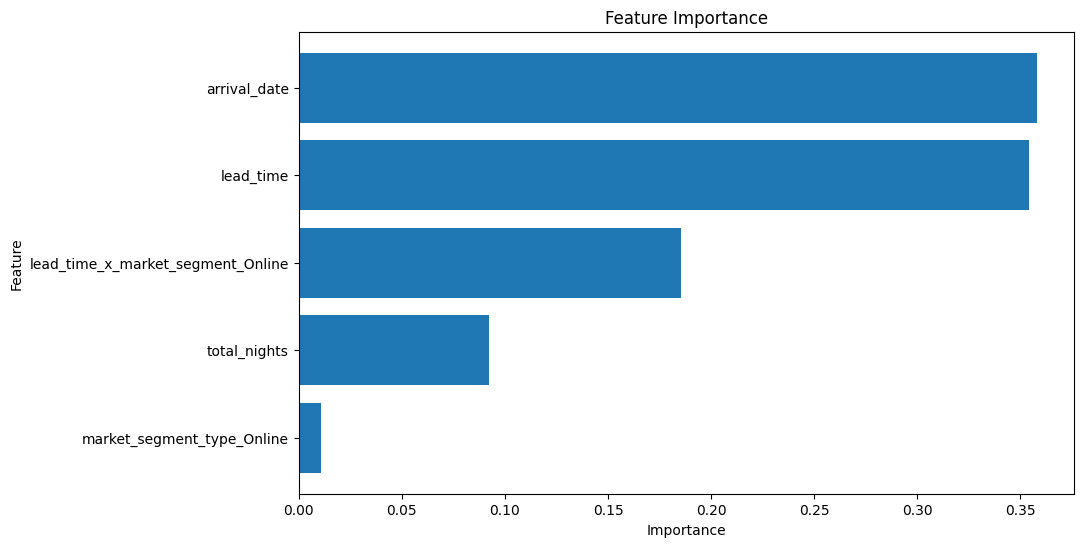

In [27]:
# Model Interpretation and Insights
# Feature Importance
# We analyze feature importance to understand which features are driving the model's decisions
import matplotlib.pyplot as plt
import pandas as pd

# Get feature importances
feature_importances = best_rf_random.feature_importances_

# Create a DataFrame for visualization
features_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
features_df = features_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(features_df['Feature'], features_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()


Based on the feature importance chart, most variables in the dataset are arrival_date and lead_time.  These two features stand significantly more than the others, with importance scores more than 1.5 times higher than the next most important feature.

In general, arrival_date and lead_time are critical features that provide valuable insights into customer behaviour, demand patterns, and operational planning. Their high importance scores indicate that they play a significant role in the predictive model or analysis, helping to drive more informed and effective decision-making.